In [1]:
import numpy as np
import _pickle as pkl
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_osc_withGT_8C12919B740845539C0E75B5CBAF7965.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan/osc"),
 'device': 'cuda:0',
 'up_to_n_pred': 8,
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [3]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device) / 100.0
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)
    
actions = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

In [4]:
from utils import load_vh_models, frame_stack
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [9]:
dict_of_models = load_models_dir(args.models_dir)
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        
        model_name = path.split("/")[-1]
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        def encode(nets, x_img, x_ft, x_arm, ctx_img):
            # Prepare context data depending on model
            if model_args.context_modality != "none":
                if model_args.context_modality == "joint": 
                    ctx = torch.cat((x_ft, x_arm), dim=-1) # (n, l, f, 12)
                elif model_args.context_modality == "ft": 
                    ctx = x_ft
                elif model_args.context_modality == "arm":
                    ctx = x_arm
                ctx = ctx.float().to(device=args.device) # (n, l, f, 6)
                ctx = ctx.transpose(-1, -2)
                ctx = ctx.reshape(-1, *ctx.shape[2:])  
                    
            # Encode
            z_all_enc = []

            z_img = nets["img_enc"](x_img)
            z_all_enc.append(z_img)              
            
            context = {}
            if model_args.context_modality != "none":
                z_context = nets["context_enc"](ctx)
                z_all_enc.append(z_context)
                context["z_context"] = z_context
            if model_args.context=="initial_latent_state":
                z_img_context = nets["context_img_enc"](ctx_img)
                z_all_enc.append(z_img_context)
                context["z_img_context"] = z_img_context

            # Concatenate modalities and mix
            z_cat_enc = torch.cat(z_all_enc, dim=1)
            z, mu_z, logvar_z = nets["mix"](z_cat_enc)
            var_z = torch.diag_embed(torch.exp(logvar_z))
            return z, mu_z, var_z, context
        
        if model_args.dim_x[0] == 1:
            imgs = data['img_gray']
        elif model_args.dim_x[0] == 3:
            imgs = data['img_rgb']
        
        total_len = imgs.shape[1]
        T = model_args.frame_stacks

        analysis_data[model_name] = {}
        for n_pred in range(1, args.up_to_n_pred + 1):
            analysis_data[model_name][f"{n_pred}_pred"] = {}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] = 0

#             for ii in range(T, total_len - n_pred):
            ii = T
            x_img_i = imgs[:, (ii - 1):(ii + 1)] 
            x_img_i = frame_stack(x_img_i, frames=T)[:, 0]

            x_img_gt = imgs[:, (ii + n_pred - 1):(ii + n_pred + 1)]
            x_img_gt = frame_stack(x_img_gt, frames=T)[:, 0]

            if model_args.context=="initial_latent_state":
                ctx_img = x_img_i  
            else:
                ctx_img = None

            x_ft_i = data['haptic'][:, ii:(ii + 1)]
            x_ft_gt = data['haptic'][:, (ii + n_pred):(ii + n_pred + 1)]

            x_arm_i = data['arm'][:, ii:(ii + 1)]                 
            x_arm_gt = data['arm'][:, (ii + n_pred):(ii + n_pred + 1)]

            z_gt, mu_z_gt, var_z_gt, _ = encode(nets, x_img_gt, x_ft_gt, x_arm_gt, ctx_img)

            u = actions[:, (ii + 1):(ii + n_pred + 1)]

            # Encode
            z_i, mu_z_i, var_z_i, context = encode(nets, x_img_i, x_ft_i, x_arm_i, ctx_img)
            h_i = None

            # Predict
            for jj in range(n_pred):
                z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                    z_t=z_i, 
                    mu_t=mu_z_i, 
                    var_t=var_z_i, 
                    u=u[:, jj], 
                    h_0=h_i, 
                    single=True
                )
                z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    

            # Decode 
            z_all_dec = []
            z_hat = z_ip1
            z_all_dec.append(z_hat)

            if model_args.context=="initial_latent_state":
                z_img_context = context["z_img_context"]
                z_img_context_rep = z_img_context
                z_all_dec.append(z_img_context_rep)

            z_cat_dec = torch.cat(z_all_dec, dim=1)
            x_hat = nets["img_dec"](z_cat_dec)

            x_hat = x_hat[:, 0:1].view(x_hat.shape[0], -1).cpu().numpy()
            x_img_gt = x_img_gt[:, 0:1].view(x_img_gt.shape[0], -1).cpu().numpy()
            z_hat = z_hat.cpu().numpy()
            z_gt = z_gt.cpu().numpy()

            n = x_img_gt.shape[0]
            print("prediction length", n_pred, "starting position", ii,
                "mse img: ", (np.sum((x_img_gt - x_hat)**2) / n),
                "mse z: ", (np.sum((z_gt - z_hat)**2) / n))
            print()

            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] += (np.sum((x_img_gt - x_hat)**2) / n)
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] += (np.sum((z_gt - z_hat)**2) / n)

            batch_ssim = 0
            batch_psnr = 0
            for jj in range(n):
                batch_ssim += ssim(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                )
                analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] += psnr(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                )

            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] += (batch_ssim / n)
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] += (batch_psnr / n)
    
            # Average MSE/SSIM/PSNR per image 
#             for k in analysis_data[model_name][f"{n_pred}_pred"]:
#                 analysis_data[model_name][f"{n_pred}_pred"][k] /= (total_len - n_pred - 1)

    print("DONE!")

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/z16_net512_l0_lm_ul_osc_v_r0.95_kl0.80_lr3e4
(1600, 4096)
prediction length 1 starting position 1 mse img:  0.6712905120849609 mse z:  67.80466796875

(1600, 4096)
prediction length 2 starting position 1 mse img:  1.3957891845703125 mse z:  32.52247314453125

(1600, 4096)
prediction length 3 starting position 1 mse img:  2.7664968872070315 mse z:  16.64196044921875

(1600, 4096)
prediction length 4 starting position 1 mse img:  4.829345092773438 mse z:  13.8326416015625

(1600, 4096)
prediction length 5 starting position 1 mse img:  7.40890625 mse z:  18.437545166015624

(1600, 4096)
prediction length 6 starting position 1 mse img:  10.439111328125 mse z:  26.637470703125

(1600, 4096)
prediction length 7 starting position 1 mse img:  14.173253173828124 mse z:  38.1499853515625

(1600, 4096)
prediction length 8 starting position 1 mse img:  17.988245849609374 mse z:  47.8437109375

Loading models in 

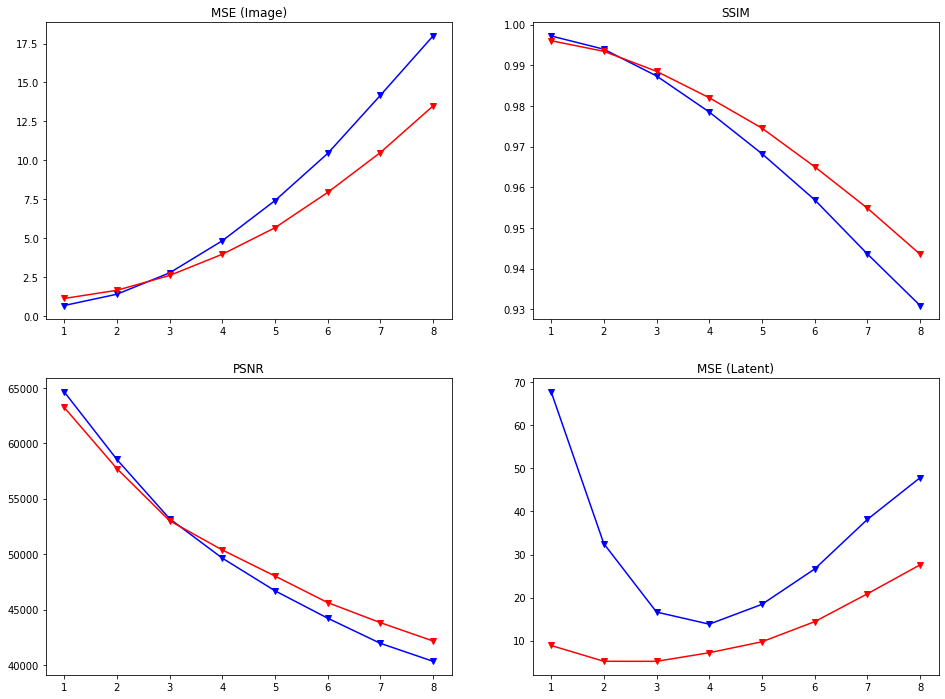

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16,12))

def add_data_to_plot(name, data):
    properties = name.split("_")
    
    # Map model properties to line properties here
    if "vha" in properties:
        color = "r"
    else:
        color = "b"
        
    if "4step" in properties:
        linestyle = "-."
    else:
        linestyle = "-"
        
    if "nl" in properties:
        marker = "o"
    else:
        marker = "v"
    
    plot_data = {'MSE_x': [], 'SSIM': [], 'PSNR': [], "MSE_z": []}
    for k, v in data.items():
        plot_data['MSE_x'].append(v['MSE_x'])
        plot_data['SSIM'].append(v['SSIM'])
        plot_data['PSNR'].append(v['PSNR'])
        plot_data['MSE_z'].append(v['MSE_z'])

    axs[0,0].plot(
        list(range(1, len(plot_data['MSE_x']) + 1)), 
        plot_data['MSE_x'],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    axs[0,1].plot(
        list(range(1, len(plot_data['SSIM']) + 1)), 
        plot_data['SSIM'],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    axs[1,0].plot(
        list(range(1, len(plot_data['PSNR']) + 1)), 
        plot_data['PSNR'],
        color=color,
        linestyle=linestyle,
        marker=marker
    )
    axs[1,1].plot(
        list(range(1, len(plot_data['MSE_z']) + 1)), 
        plot_data['MSE_z'],
        color=color,
        linestyle=linestyle,
        marker=marker
    )

axs[0,0].set_title("MSE (Image)")
axs[0,1].set_title("SSIM")
axs[1,0].set_title("PSNR")
axs[1,1].set_title("MSE (Latent)")

for k, v in analysis_data.items():
    add_data_to_plot(k, v)